# Imbalanced Datasets

### GIST:
The goal of this assignment is to build a model that can reliably predict whether a client will subscribe to this term deposit based on their demographics and previous contact details from the Bank csv. You will notice that, without much effort, you can build a model that gives you a very high ‘accuracy’ score. However, this metric is misleading since the model cannot correctly classify instances of the minority class (‘1’ in this case). This can be attributed to the  inherent imbalance present in the target column of the dataset.  

To solve this issue, you will need to employ certain ML techniques that are designed to counter class imbalance. Hence, the focus of this assignment will be towards addressing class imbalance and testing the model using different evaluation metrics other than just accuracy.

In [61]:
#libraries
#Import below any other packages you need for your solution
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, auc, roc_curve,classification_report,ConfusionMatrixDisplay
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [62]:
#Read the dataset
df = pd.read_csv('/content/bank-data.csv')
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### **1. Examining Class Imbalance.**

a. Examine the class imbalance in the target column. What is its class distribution? Show this information visually using an appropriate scale. </br>
b. What is the degree of imbalance? (Mild/Moderate/Extreme)

<ipython-input-63-de02a89668a3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(x=value_counts.index, y=value_counts.values, palette='Pastel2')


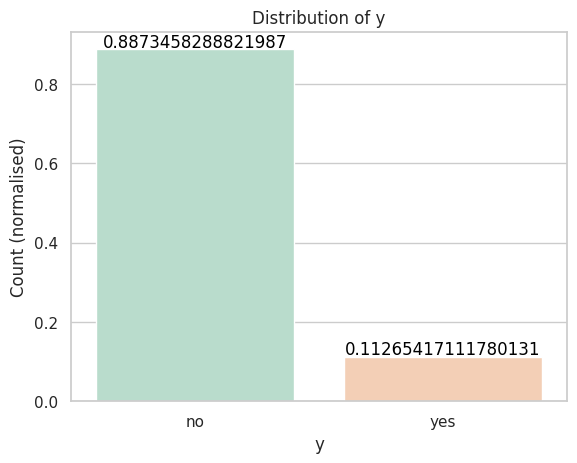

In [63]:
#Your code here
sns.set(style="whitegrid")
value_counts = df['y'].value_counts(normalize=True)

ax=sns.barplot(x=value_counts.index, y=value_counts.values, palette='Pastel2')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.title('Distribution of y')
plt.xlabel('y')
plt.ylabel('Count (normalised)')
plt.show()

<ipython-input-64-3576f8006dd2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(x='y', data=df, palette='Pastel2')


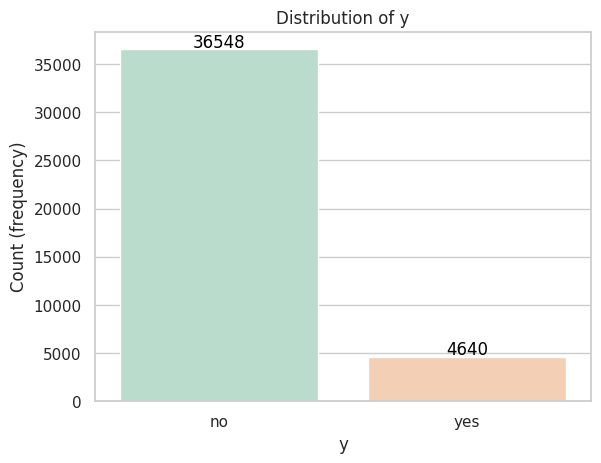

In [64]:
#Your code here

sns.set(style="whitegrid")

ax=sns.countplot(x='y', data=df, palette='Pastel2')
plt.title('Distribution of y')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.xlabel('y')
plt.ylabel('Count (frequency)')
plt.show()

##b

There is 4640 'yes' in a total of 41188 data points, which means the percentage of minority class is `(4640/41188)*100 = 11.26%`. Since it is between 10%-30% of the entire dataset, the degree of imbalance is **moderate**.

### **2. Pre-processing**


a. Split the dataset into development and test sets. What splitting methodology did you choose, and why? </br>
b. Encode the categorical variables. </br>
c. Scale numerical columns. </br>
d. Encode the target variable. </br>
e. Print the shape of the development and test set.

In [65]:
#Your code here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [66]:
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
housing,0
loan,0
contact,0
month,0
day_of_week,0


In [67]:
categorical_features=[]
for x in df.columns:
  if df[x].dtype=='object':
    categorical_features.append(x)

categorical_features = categorical_features[:-1] ## exclude 'y'


In [68]:
encoder = OneHotEncoder(sparse_output=False)
encoded_values = encoder.fit_transform(df[categorical_features])

encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names_out(categorical_features))

df = pd.concat([df.drop(columns=categorical_features), encoded_df], axis=1)

df

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [69]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 64 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  int64  
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  int64  
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  int64  
 11  job_admin.                     41188 non-null  float64
 12  job_blue-collar                41188 non-null 

In [71]:
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [72]:

print("Shape of the development set")
print(f"Shape of X: {X_train.shape}")
print(f"Shape of y majority class (y='no' or 0): {y_train[y_train==0].shape}")
print(f"Shape of y minority class (y='yes' or 1): {y_train[y_train==1].shape}")
print(f"Proportion of y:\n {y_train.value_counts(normalize=True)}")


print("\n\nShape of the test set")
print(f"Shape of X: {X_test.shape}")
print(f"Shape of y majority class (y='no' or 0): {y_test[y_test==0].shape}")
print(f"Shape of y minority class (y='yes' or 1): {y_test[y_test==1].shape}")
print(f"Proportion of y:\n {y_test.value_counts(normalize=True)}")

Shape of the development set
Shape of X: (32950, 63)
Shape of y majority class (y='no' or 0): (29238,)
Shape of y minority class (y='yes' or 1): (3712,)
Proportion of y:
 y
0    0.887344
1    0.112656
Name: proportion, dtype: float64


Shape of the test set
Shape of X: (8238, 63)
Shape of y majority class (y='no' or 0): (7310,)
Shape of y minority class (y='yes' or 1): (928,)
Proportion of y:
 y
0    0.887351
1    0.112649
Name: proportion, dtype: float64


In [73]:
ss=StandardScaler()
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.transform(X_test)
X_train_std

array([[ 0.86373877, -0.12019627,  0.52298128, ..., -0.34081462,
         0.39944711, -0.18627755],
       [-0.28972159, -0.2167318 , -0.20368791, ...,  2.93414647,
        -2.50346033, -0.18627755],
       [ 3.65126795,  3.43617293, -0.56702251, ..., -0.34081462,
         0.39944711, -0.18627755],
       ...,
       [ 1.34434725, -0.49089273,  0.52298128, ..., -0.34081462,
         0.39944711, -0.18627755],
       [-1.05869515, -0.3596044 , -0.56702251, ..., -0.34081462,
         0.39944711, -0.18627755],
       [-0.48196498,  1.10387435,  0.15964669, ..., -0.34081462,
         0.39944711, -0.18627755]])

## Comment

The splitting technique used is 'stratified' as there's moderate imbalance in the target feature. This ensures that the proportion of the presence of majority and minority classes in the dataset is maintained in both the development and test sets.

Development set:  ```(3712/32950)*100 = 11.26%```


Test set: ```(928/8238)*100 = 11.26%```

Whole dataset: ```(4640/41188)*100 = 11.26%```


I've applied SMOTE, Random Oversampling and Random Undersampling on unscaled data and then scaled it when passing it as input for fitting the Decision Tree model, as there is a possibility that scaling before applying these techniques might disrupt the distribution (Standard Scaler).


### 3.1 Default Dataset
Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation </br>

In [74]:
#Your Code Here
d={'default':[], 'balanced':[], 'random_oversampling':[], 'random_undersampling':[], 'smote':[]}
scores=cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), X_train_std, y_train,
                      cv=5, scoring=["roc_auc", "average_precision"])
scores

{'fit_time': array([0.23988986, 0.23798537, 0.20144582, 0.20774341, 0.19902563]),
 'score_time': array([0.01334   , 0.00627065, 0.00623155, 0.00718331, 0.00671721]),
 'test_roc_auc': array([0.8637376 , 0.86078925, 0.84397919, 0.85131785, 0.86606768]),
 'test_average_precision': array([0.53076612, 0.52713769, 0.47904721, 0.51471149, 0.5402459 ])}

In [75]:
d['default'].append(scores['test_roc_auc'].mean())
scores['test_average_precision'].mean(), scores['test_roc_auc'].mean()

(np.float64(0.5183816817418755), np.float64(0.8571783127134701))

### 3.2 Balanced Weight

a. Here, we are going to use a 'balanced' decision tree clasifier on the same dataset. Use max_depth=10 and random_state=42, and then print the AUC and Average Precision values of 5 Fold Cross Validation.

In [76]:
#Your Code Here
scores=cross_validate(DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42), X_train_std, y_train,
                      cv=5, scoring=["roc_auc", "average_precision"])
scores

{'fit_time': array([0.20627117, 0.20127845, 0.18556714, 0.20728755, 0.19439173]),
 'score_time': array([0.00762272, 0.00627923, 0.00650334, 0.00613999, 0.00609517]),
 'test_roc_auc': array([0.89391886, 0.89695662, 0.88990004, 0.87799831, 0.8728074 ]),
 'test_average_precision': array([0.58064464, 0.58634398, 0.5370929 , 0.53713986, 0.57358949])}

In [77]:
d['balanced'].append(scores['test_roc_auc'].mean())
scores['test_average_precision'].mean(), scores['test_roc_auc'].mean()

(np.float64(0.5629621752074714), np.float64(0.8863162440802936))

### 3.3 Random Oversampling

a. Perform random oversampling on the development dataset. (Please set random state to 42 while doing this).
Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [78]:
#Your Code Here
ros=RandomOverSampler(random_state=42)
X_train_ros, y_train_ros=ros.fit_resample(X_train, y_train)

X_train_ros=ss.fit_transform(X_train_ros)
X_test_ros=ss.transform(X_test)

print(X_train_ros.shape)
print(y_train_ros.value_counts())

(58476, 63)
y
0    29238
1    29238
Name: count, dtype: int64


In [79]:
#Your Code Here

scores=cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), X_train_ros, y_train_ros,
                      cv=5, scoring=["roc_auc", "average_precision"])
scores

{'fit_time': array([0.42078304, 0.36806846, 0.35363817, 0.35043263, 0.39728975]),
 'score_time': array([0.01904893, 0.00853014, 0.008322  , 0.00834346, 0.01260257]),
 'test_roc_auc': array([0.95622992, 0.95560461, 0.95239272, 0.95326415, 0.95257479]),
 'test_average_precision': array([0.93518714, 0.93085165, 0.92755288, 0.92880013, 0.92426813])}

In [80]:
d['random_oversampling'].append(scores['test_roc_auc'].mean())
scores['test_average_precision'].mean(), scores['test_roc_auc'].mean()

(np.float64(0.9293319861286584), np.float64(0.9540132356358504))

### 3.4 Random Undersampling

a. Perform random undersampling on the development dataset. (Please set random state to 42 while doing this).
Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [81]:
#Your Code Here
rus=RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus=rus.fit_resample(X_train, y_train)

X_train_rus=ss.fit_transform(X_train_rus)
X_test_rus=ss.transform(X_test)


print(X_train_rus.shape)
print(y_train_rus.value_counts())

(7424, 63)
y
0    3712
1    3712
Name: count, dtype: int64


In [82]:
#Your Code Here
scores=cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), X_train_rus, y_train_rus,
                      cv=5, scoring=["roc_auc", "average_precision"])
scores

{'fit_time': array([0.0663228 , 0.06480503, 0.0599544 , 0.06854343, 0.06111002]),
 'score_time': array([0.00792336, 0.00617528, 0.00699854, 0.00640297, 0.00586104]),
 'test_roc_auc': array([0.881242  , 0.88008293, 0.87248733, 0.88212717, 0.89104627]),
 'test_average_precision': array([0.84864709, 0.84195658, 0.82043345, 0.83796623, 0.84182744])}

In [83]:
d['random_undersampling'].append(scores['test_roc_auc'].mean())
scores['test_average_precision'].mean(), scores['test_roc_auc'].mean()

(np.float64(0.8381661573544665), np.float64(0.8813971392780895))

### 3.5 SMOTE

a. Perform Synthetic Minority Oversampling Technique (SMOTE) on the development dataset. (Please set random state to 42 while doing this). Examine the target column again. What is its class distribution now? Print the shape of the development set. </br>

b. Repeat part 3.1 again. Use the Decision tree classifier (use max_depth=10 and random_state=42) model and print the AUC and Average Precision values of 5 Fold Cross Validation

In [84]:
#Your Code Here
smote=SMOTE(random_state=42)
X_train_sm, y_train_sm=smote.fit_resample(X_train, y_train)

X_train_sm=ss.fit_transform(X_train_sm)
X_test_sm=ss.transform(X_test)

print(X_train_sm.shape)
print(y_train_sm.value_counts())

(58476, 63)
y
0    29238
1    29238
Name: count, dtype: int64


In [85]:
#Your Code Here

scores=cross_validate(DecisionTreeClassifier(max_depth=10, random_state=42), X_train_sm, y_train_sm,
                      cv=5, scoring=["roc_auc", "average_precision"])
scores

{'fit_time': array([1.21601439, 0.71755838, 0.69427299, 0.7019608 , 0.68970108]),
 'score_time': array([0.02649164, 0.00865531, 0.00790811, 0.00835562, 0.0080626 ]),
 'test_roc_auc': array([0.85231246, 0.98494757, 0.98035038, 0.98503114, 0.98395551]),
 'test_average_precision': array([0.89347821, 0.97893001, 0.97034296, 0.97869048, 0.9768811 ])}

In [86]:
d['smote'].append(scores['test_roc_auc'].mean())
scores['test_average_precision'].mean(), scores['test_roc_auc'].mean()

(np.float64(0.9596645536039032), np.float64(0.9573194122064719))

### 3.6 Visual Comparison

Prepare a plot comparing the class distribtion of the target column for each of the imbalance techiques used above. Use the default class split as well.

In [87]:
#Your Code Here
imb={
    'techniques':['Default', 'Random Undersampling', 'Random Oversampling', 'Balanced Weight', 'SMOTE'],
    'no':[29238, 3712, 29238, 29238, 29238],
    'yes':[3712, 3712, 29238, 3712, 29238]
}

imb_df = pd.DataFrame(imb)
imb_df

,techniques,no,yes
0,Default,29238,3712
1,Random Undersampling,3712,3712
2,Random Oversampling,29238,29238
3,Balanced Weight,29238,3712
4,SMOTE,29238,29238


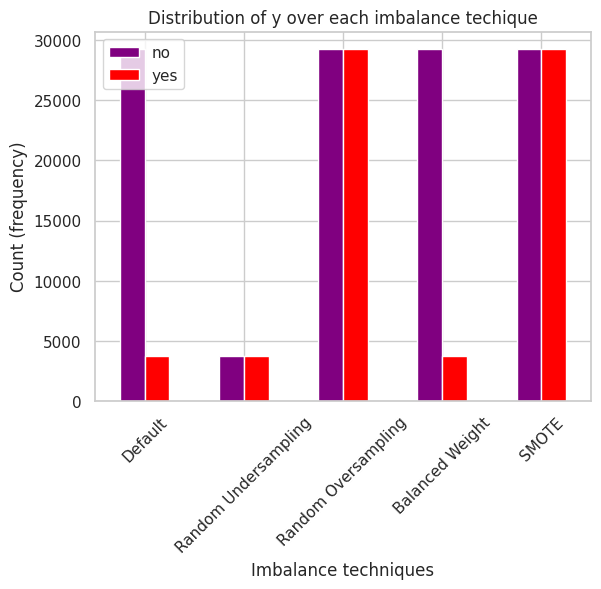

In [88]:

imb_df.plot(x='techniques', kind='bar', title='Distribution of y over each imbalance techique', color=['purple', 'red'])
plt.xlabel('Imbalance techniques')
plt.ylabel('Count (frequency)')
plt.xticks(rotation=45)
plt.show()

### **4.1: Model Prediction & Evaluation - AUC Scores**
Make predictions on the test set using the five models that you built and report their AUC values<br>
(Five models include models from - Default Baseline, Random Undersampling, Random Oversampling, SMOTE & Balanced Weight). Did the models with high AUC scores on the development set exhibit similar performance on the test set? Explain.

In [89]:
#Your Code Here
dt=DecisionTreeClassifier(max_depth=10, random_state=42)
dt_balanced=DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')

In [90]:
dt.fit(X_train_std, y_train)
y_pred_base=dt.predict(X_test_std)
y_pred_base_proba = dt.predict_proba(X_test_std)[:, 1]
d['default'].append(roc_auc_score(y_test, y_pred_base))
roc_auc_score(y_test, y_pred_base)

np.float64(0.743393998537667)

In [91]:
dt_balanced.fit(X_train_std, y_train)
y_pred_balanced=dt_balanced.predict(X_test_std)
y_pred_balanced_proba = dt_balanced.predict_proba(X_test_std)[:, 1]
d['balanced'].append(roc_auc_score(y_test, y_pred_balanced))
roc_auc_score(y_test, y_pred_balanced)

np.float64(0.8710517005519128)

In [92]:
dt.fit(X_train_ros, y_train_ros)
y_pred_ros=dt.predict(X_test_ros)
y_pred_ros_proba = dt.predict_proba(X_test_ros)[:, 1]
d['random_oversampling'].append(roc_auc_score(y_test, y_pred_ros))
roc_auc_score(y_test, y_pred_ros)

np.float64(0.8707433133638379)

In [93]:
dt.fit(X_train_rus, y_train_rus)
y_pred_rus=dt.predict(X_test_rus)
y_pred_rus_proba = dt.predict_proba(X_test_rus)[:, 1]
d['random_undersampling'].append(roc_auc_score(y_test, y_pred_rus))
roc_auc_score(y_test, y_pred_rus)

np.float64(0.8735752570875985)

In [94]:
dt.fit(X_train_sm, y_train_sm)
y_pred_sm=dt.predict(X_test_sm)
y_pred_sm_proba = dt.predict_proba(X_test_sm)[:, 1]
d['smote'].append(roc_auc_score(y_test, y_pred_sm))
roc_auc_score(y_test, y_pred_sm)

np.float64(0.7989123897353648)

In [95]:
d

{'default': [np.float64(0.8571783127134701), np.float64(0.743393998537667)],
 'balanced': [np.float64(0.8863162440802936), np.float64(0.8710517005519128)],
 'random_oversampling': [np.float64(0.9540132356358504),
  np.float64(0.8707433133638379)],
 'random_undersampling': [np.float64(0.8813971392780895),
  np.float64(0.8735752570875985)],
 'smote': [np.float64(0.9573194122064719), np.float64(0.7989123897353648)]}

## Comment

**No,** the models with high AUC scores in the development set (SMOTE) performed the worst on the test set (maybe better than baseline model), suggesting that the model becomes too complex on generating more data (as same can be observed from Random Oversampling) that it does not generalize well on the test data (overfitting).

### **4.2: Model Prediction & Evaluation - Confusion Matrix**
a. Plot Confusion Matrices for all the five models on the test set. Comment on your results and share in detail. Consider precision, recall and f1 scores. <br>
b. For the dataset at hand, which evaluation metric matters most according to you? Would it make sense to prioritise either precision/recall over the other? Justify.

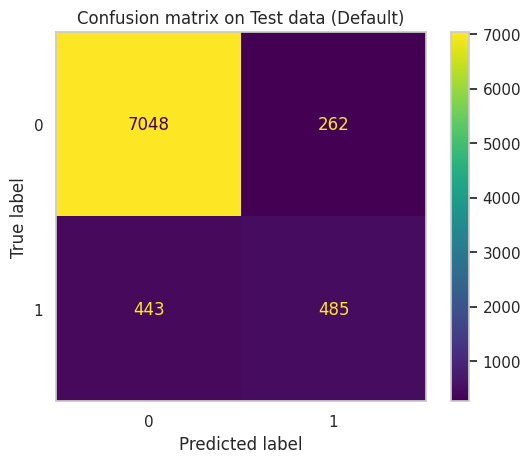

In [96]:
#Your Code Here
cm = confusion_matrix(y_test, y_pred_base, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.grid(visible=None)
plt.title("Confusion matrix on Test data (Default)")
plt.show()

In [97]:
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.65      0.52      0.58       928

    accuracy                           0.91      8238
   macro avg       0.80      0.74      0.77      8238
weighted avg       0.91      0.91      0.91      8238



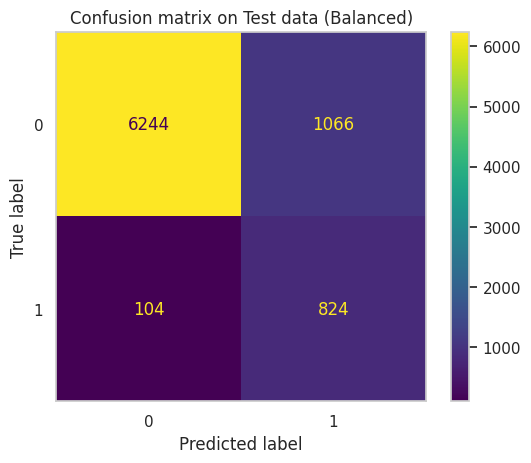

In [98]:
#Your Code Here
cm = confusion_matrix(y_test, y_pred_balanced, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.grid(visible=None)
plt.title("Confusion matrix on Test data (Balanced)")
plt.show()

In [99]:
print(classification_report(y_test, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7310
           1       0.44      0.89      0.58       928

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.88      8238



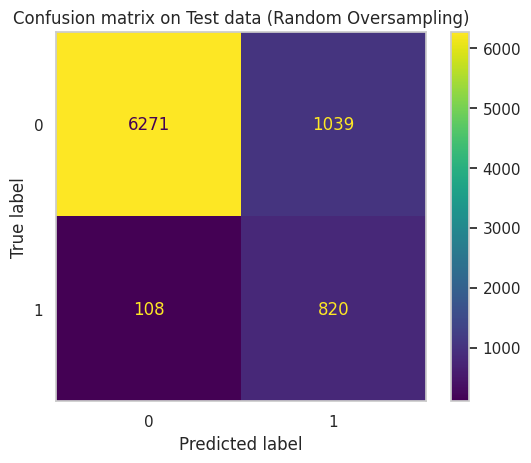

In [100]:
#Your Code Here
cm = confusion_matrix(y_test, y_pred_ros, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.grid(visible=None)
plt.title("Confusion matrix on Test data (Random Oversampling)")
plt.show()

In [101]:
print(classification_report(y_test, y_pred_ros))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7310
           1       0.44      0.88      0.59       928

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.88      8238



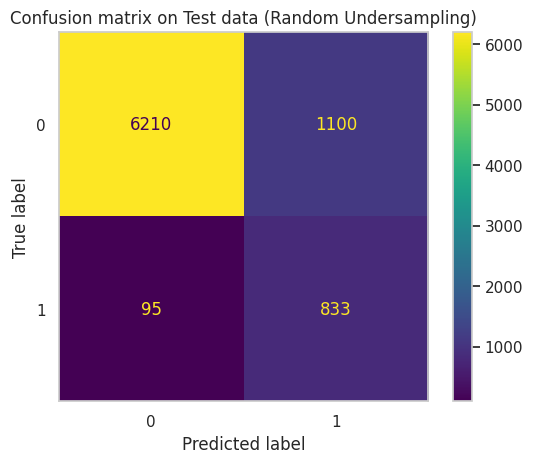

In [102]:
#Your Code Here
cm = confusion_matrix(y_test, y_pred_rus, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.grid(visible=None)
plt.title("Confusion matrix on Test data (Random Undersampling)")
plt.show()

In [103]:
print(classification_report(y_test, y_pred_rus))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7310
           1       0.43      0.90      0.58       928

    accuracy                           0.85      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.85      0.88      8238



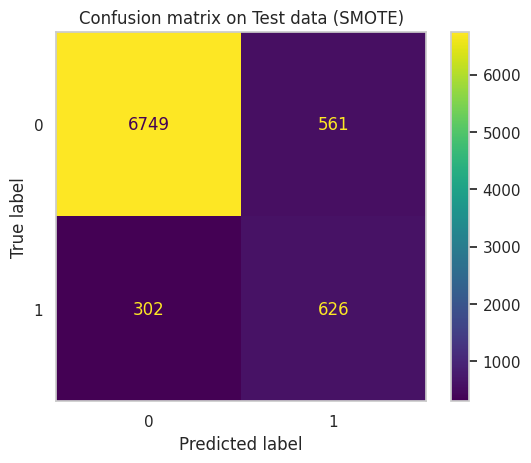

In [104]:
#Your Code Here
cm = confusion_matrix(y_test, y_pred_sm, labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dt.classes_)
disp.plot()
plt.grid(visible=None)
plt.title("Confusion matrix on Test data (SMOTE)")
plt.show()

In [105]:
print(classification_report(y_test, y_pred_sm))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7310
           1       0.53      0.67      0.59       928

    accuracy                           0.90      8238
   macro avg       0.74      0.80      0.77      8238
weighted avg       0.91      0.90      0.90      8238



## Comment

a) It seems like for baseline, majority of the classes predicted as 1 are indeed 1 and majority of the actual class 1 labels are also predicted correctly. For SMOTE, True positive is almost twice as that of False negatives (misclassified as 0), and majority of the classes predicted as 1 were actually 1. For the rest of the techniques, True positive is almost 8 times as that of False negatives (misclassified as 0), and majority of the classes predicted as 1 were actually 0 (False positives).

b) Since the dataset is imbalanced, I would say it is Average Precision as AP indicates whether the model can correctly identify all positive
examples without accidentally marking too many negative examples as
positive or maybe F1-score.

Choosing Precision or Recall matters on the cost.


Recall matters more when we want to minimize false negatives (i.e., customers who would subscribe to the term deposit but are classified as not subscribing). Missing these potential subscribers could lead to lost revenue or missed marketing opportunities.

Precision might be important if the cost of falsely predicting a subscription (false positives) is high (e.g., contacting customers unnecessarily).

F1-Score is useful when we want to balance precision and recall, especially if both false positives and false negatives have significant costs. Since this is a typical example of a class imbalance problem, F1-Score may give you a good balance between precision and recall.

When it comes to recall or precision, I'll assume the cost of 'customers who would subscribe to the term deposit but are classified as not subscribing' is more, so I'll choose 'Recall'.




### **4.3: Model Prediction & Evaluation - ROC Curves**

Plot ROC for all the five models on the test set in a single plot. Recomment which technique is most appropriate and why.

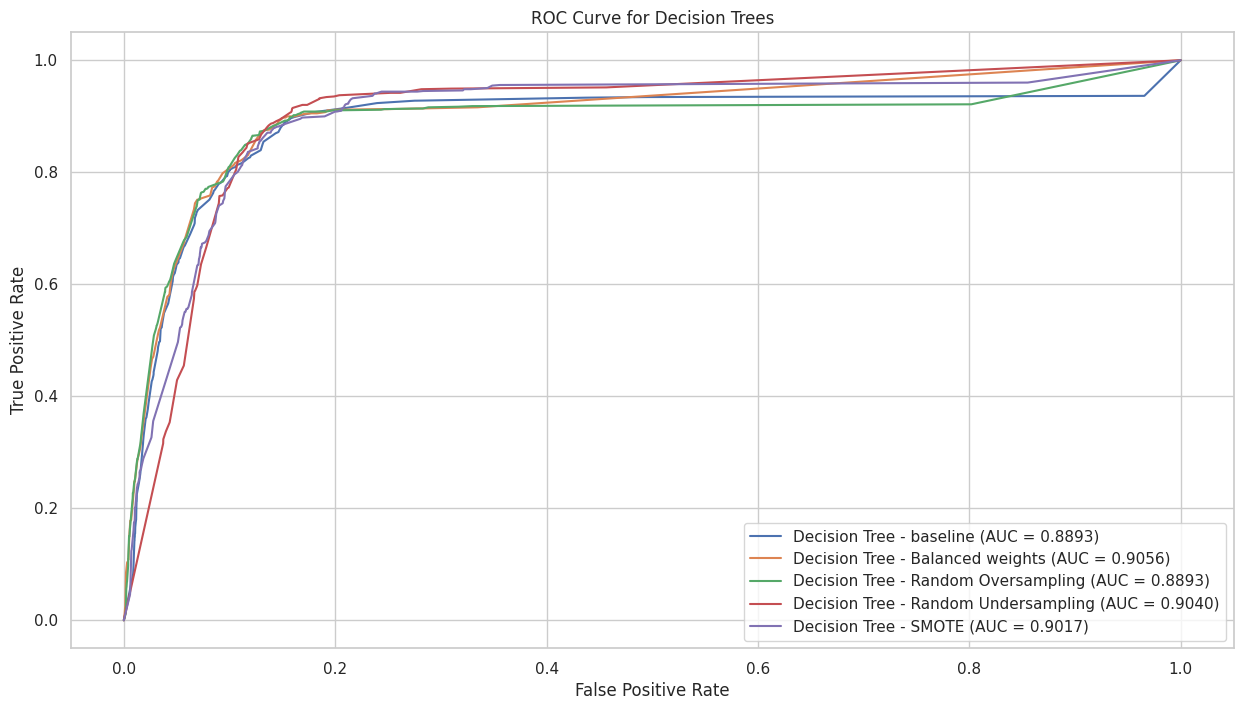

In [106]:
#Your Code Here
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_base_proba)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_balanced_proba)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_ros_proba)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, thresholds4 = roc_curve(y_test, y_pred_rus_proba)
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, thresholds5 = roc_curve(y_test, y_pred_sm_proba)
roc_auc5 = auc(fpr5, tpr5)

plt.figure(figsize=(15,8))
plt.plot(fpr1, tpr1, label='Decision Tree - baseline (AUC = %0.4f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='Decision Tree - Balanced weights (AUC = %0.4f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='Decision Tree - Random Oversampling (AUC = %0.4f)' % roc_auc3)
plt.plot(fpr4, tpr4, label='Decision Tree - Random Undersampling (AUC = %0.4f)' % roc_auc4)
plt.plot(fpr5, tpr5, label='Decision Tree - SMOTE (AUC = %0.4f)' % roc_auc5)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Trees')
plt.legend()
plt.show()

## Comment

From the AUC scores from the previous sections on both development and test set and from this plot, I would recommend that we employ **Balanced weights** technique as it has the highest AUC score and also doesn't cause overfitting problem. The techniques that I would strongly discourage are Random Oversampling and SMOTE as they perform good on develepment set but poor on test set. Only in these 2 methods do we generate more data, so them performing good on development set but not on test means that with increase in data the model becomes too complex and doesn't generalise well on unseen data (leading to Overfitting). Therefore, we should choose a technique that doesn't generate more data - Balanced weights or Random Undersampling - out of these Balanced weights has higher scores.